# Data Preprocessing: PPG Data

This notebook will preprocess the PPG data in the the WEEE dataset using the `HeartPy` library.

## Imports and Data Loading

In [12]:
# imports
import os
from envyaml import EnvYAML

import heartpy as hp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# environment configuration
VAR_ENV = EnvYAML("../../env.yaml")
DATASET_PATH = os.path.join("../..", VAR_ENV["dataset.path"])
DATASET_VERSION = VAR_ENV["dataset.version"]

In [4]:
path_list = [os.path.join(DATASET_PATH, DATASET_VERSION, f"P{i:02d}") for i in range(1, VAR_ENV["dataset.participants"] + 1)]

### Loading E4 PPG Data

PPG data of E4 device is stored in the `BVP.csv` files.

In [5]:
# loading data
ppg_e4_dfs = [pd.read_csv(os.path.join(path, "E4", "BVP.csv")) for path in path_list]

Now let's separate the frequency from the data. Also, we will reshape the dataset such that the minimum value is now 0.

In [6]:
def reshape_ppg(df, columns):
    return df[columns]+df[columns].min(axis=0).abs()

In [7]:
FREQUENCY = 64.0 # 64 Hz
ppg_e4_dfs = list(map(lambda df: pd.DataFrame(data=df.iloc[1:].values, columns=["ppg_raw"]), ppg_e4_dfs))

### Loading Earbuds PPG Data

## Analyzing the Data

### E4 PPG Data

#### Line Plots

In [8]:
def line_plots(dfs):
    fig = plt.figure(figsize=(20, 20))
    spec = fig.add_gridspec(5, 4)

    for i, df in enumerate(dfs):
        plot_df = pd.DataFrame(data=df.values, columns=["ppg_raw"])
        axes = fig.add_subplot(spec[i//4, i%4])
        axes.title.set_text(f"P{i+1}")
        axes.plot(plot_df["ppg_raw"])

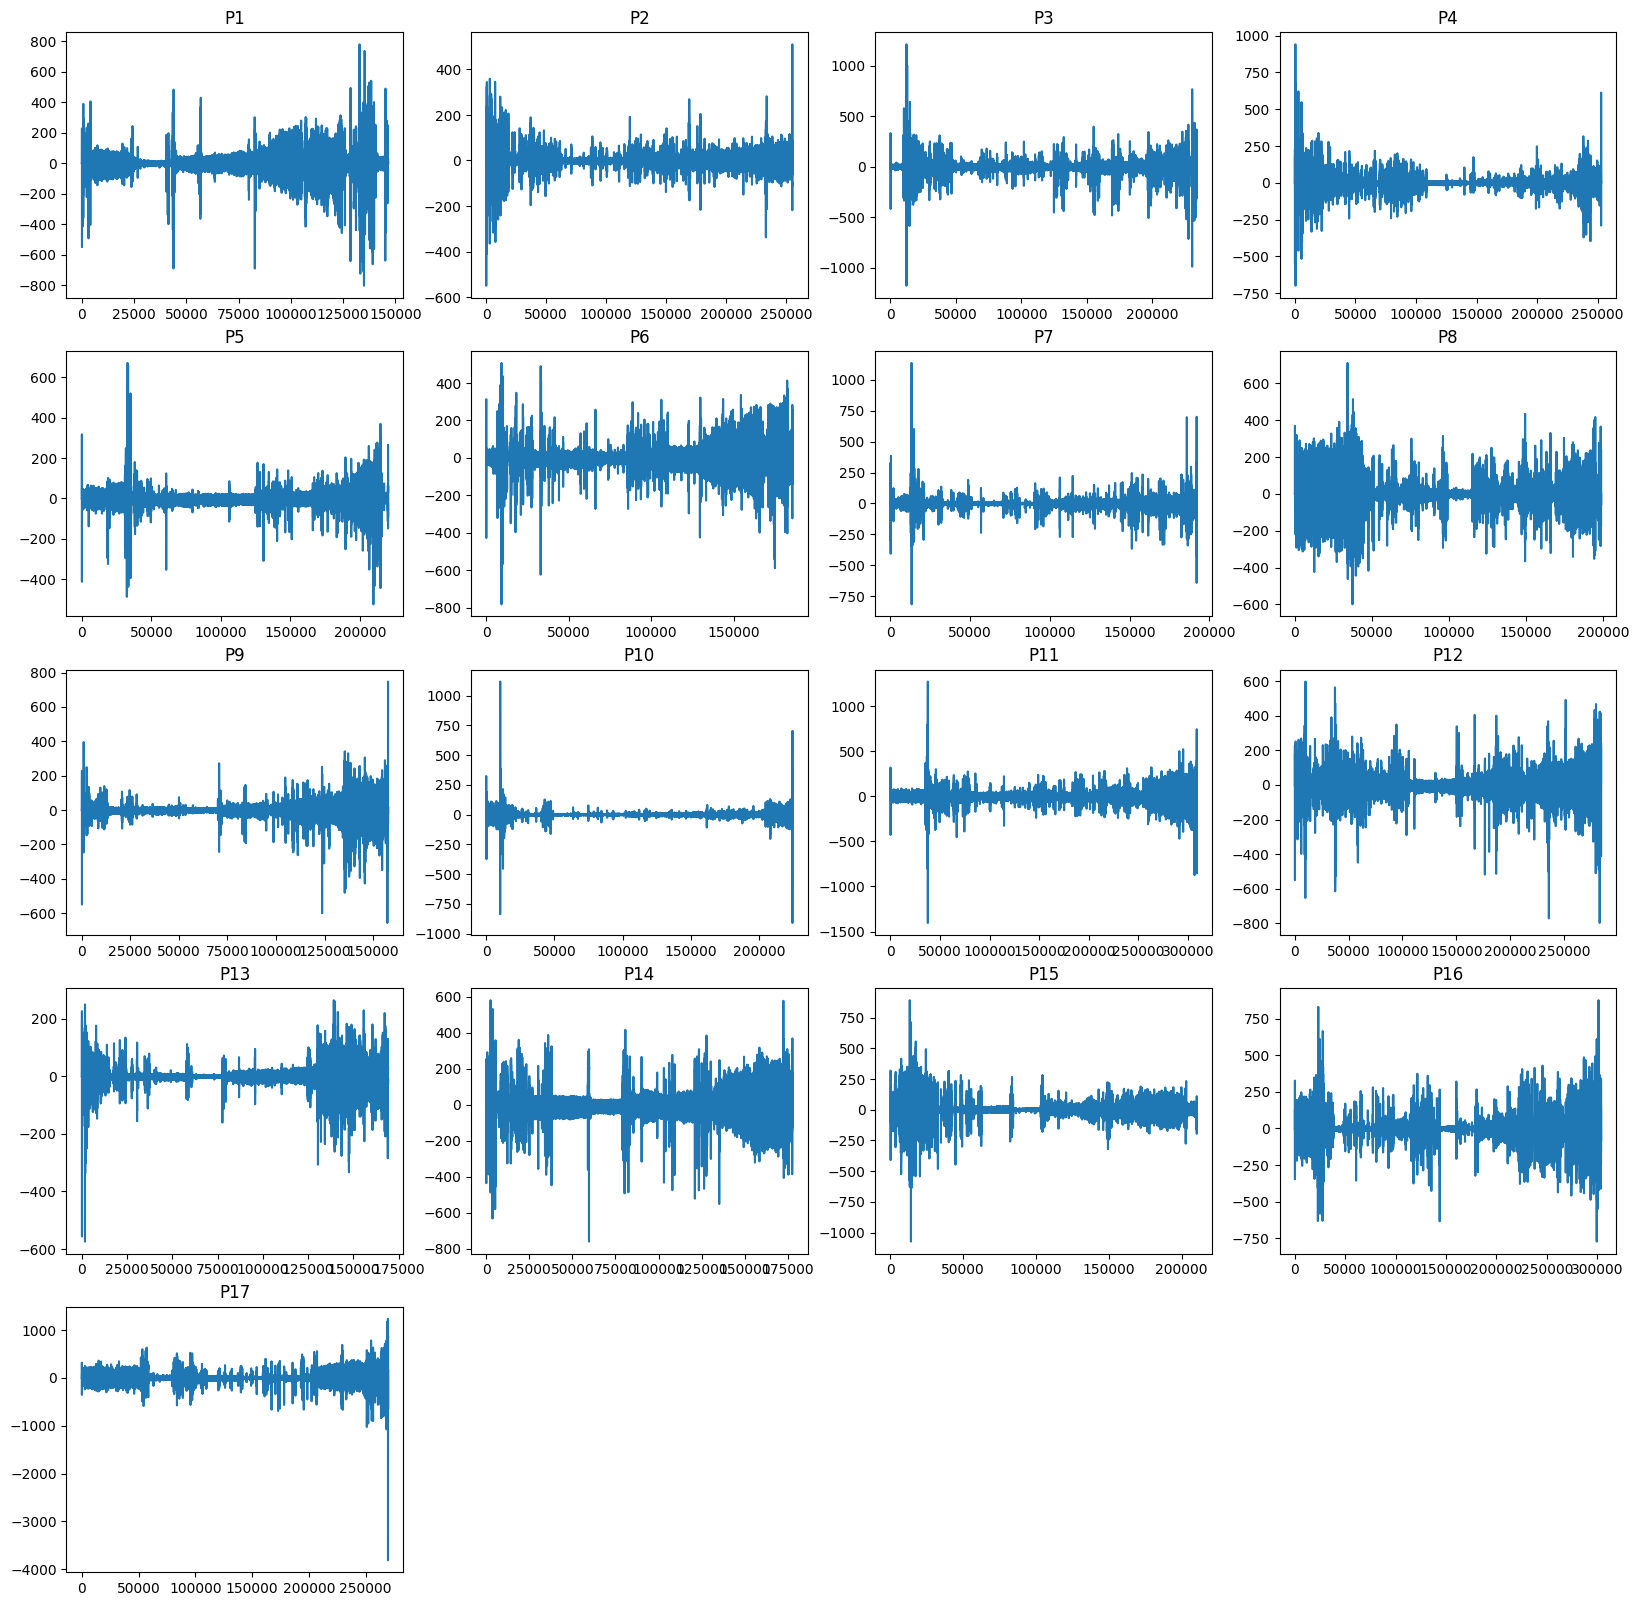

In [9]:
line_plots(ppg_e4_dfs)

#### Box Plot

In [10]:
def box_plots(dfs):
    fig = plt.figure(figsize=(20, 40))

    for i, df in enumerate(dfs):
        ax = fig.add_subplot(5, 4, i+1)
        ax.title.set_text(f"P{i+1}")
        plot_df = pd.DataFrame(data=df.values, columns=["ppg_raw"])
        sns.boxplot(data=plot_df, ax=fig.axes[i])

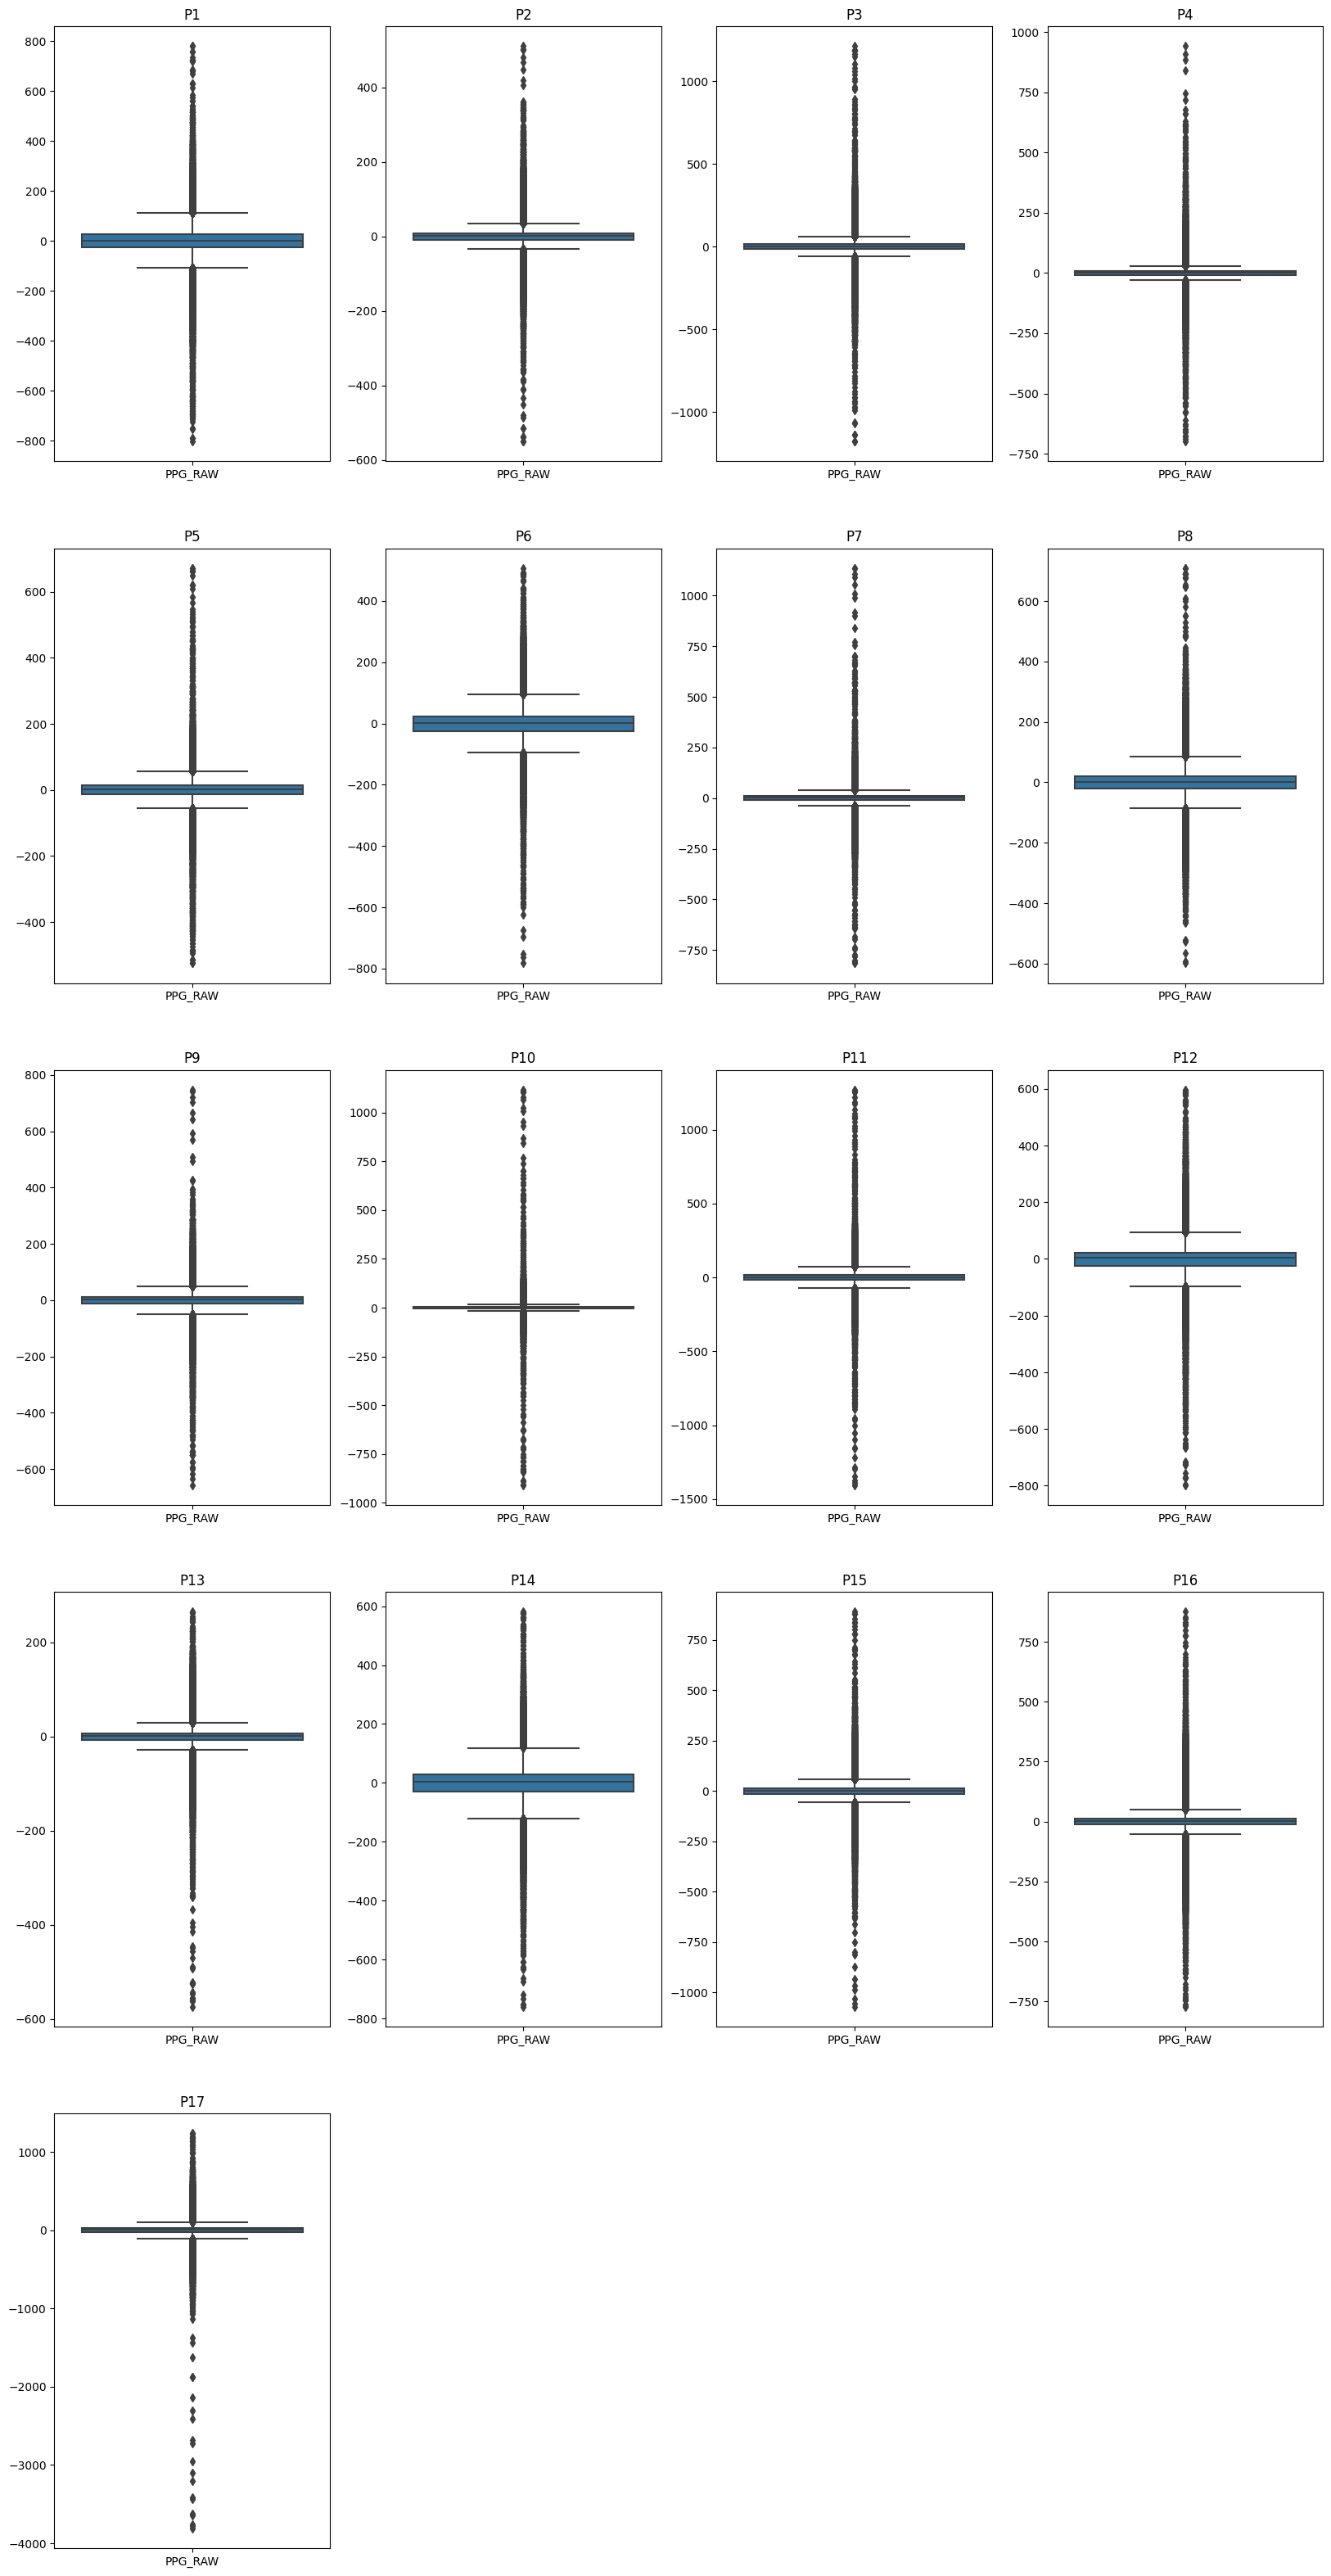

In [11]:
box_plots(ppg_e4_dfs)

#### Histogram Plots

In [12]:
def hist_plots(dfs):
    fig = plt.figure(figsize=(20, 20))

    for i, df in enumerate(dfs):
        ax = fig.add_subplot(5, 4, i+1)
        ax.title.set_text(f"P{i+1}")
        plot_df = pd.DataFrame(data=df.values, columns=["ppg_raw"])
        sns.histplot(data=plot_df, bins=20, ax=fig.axes[i])

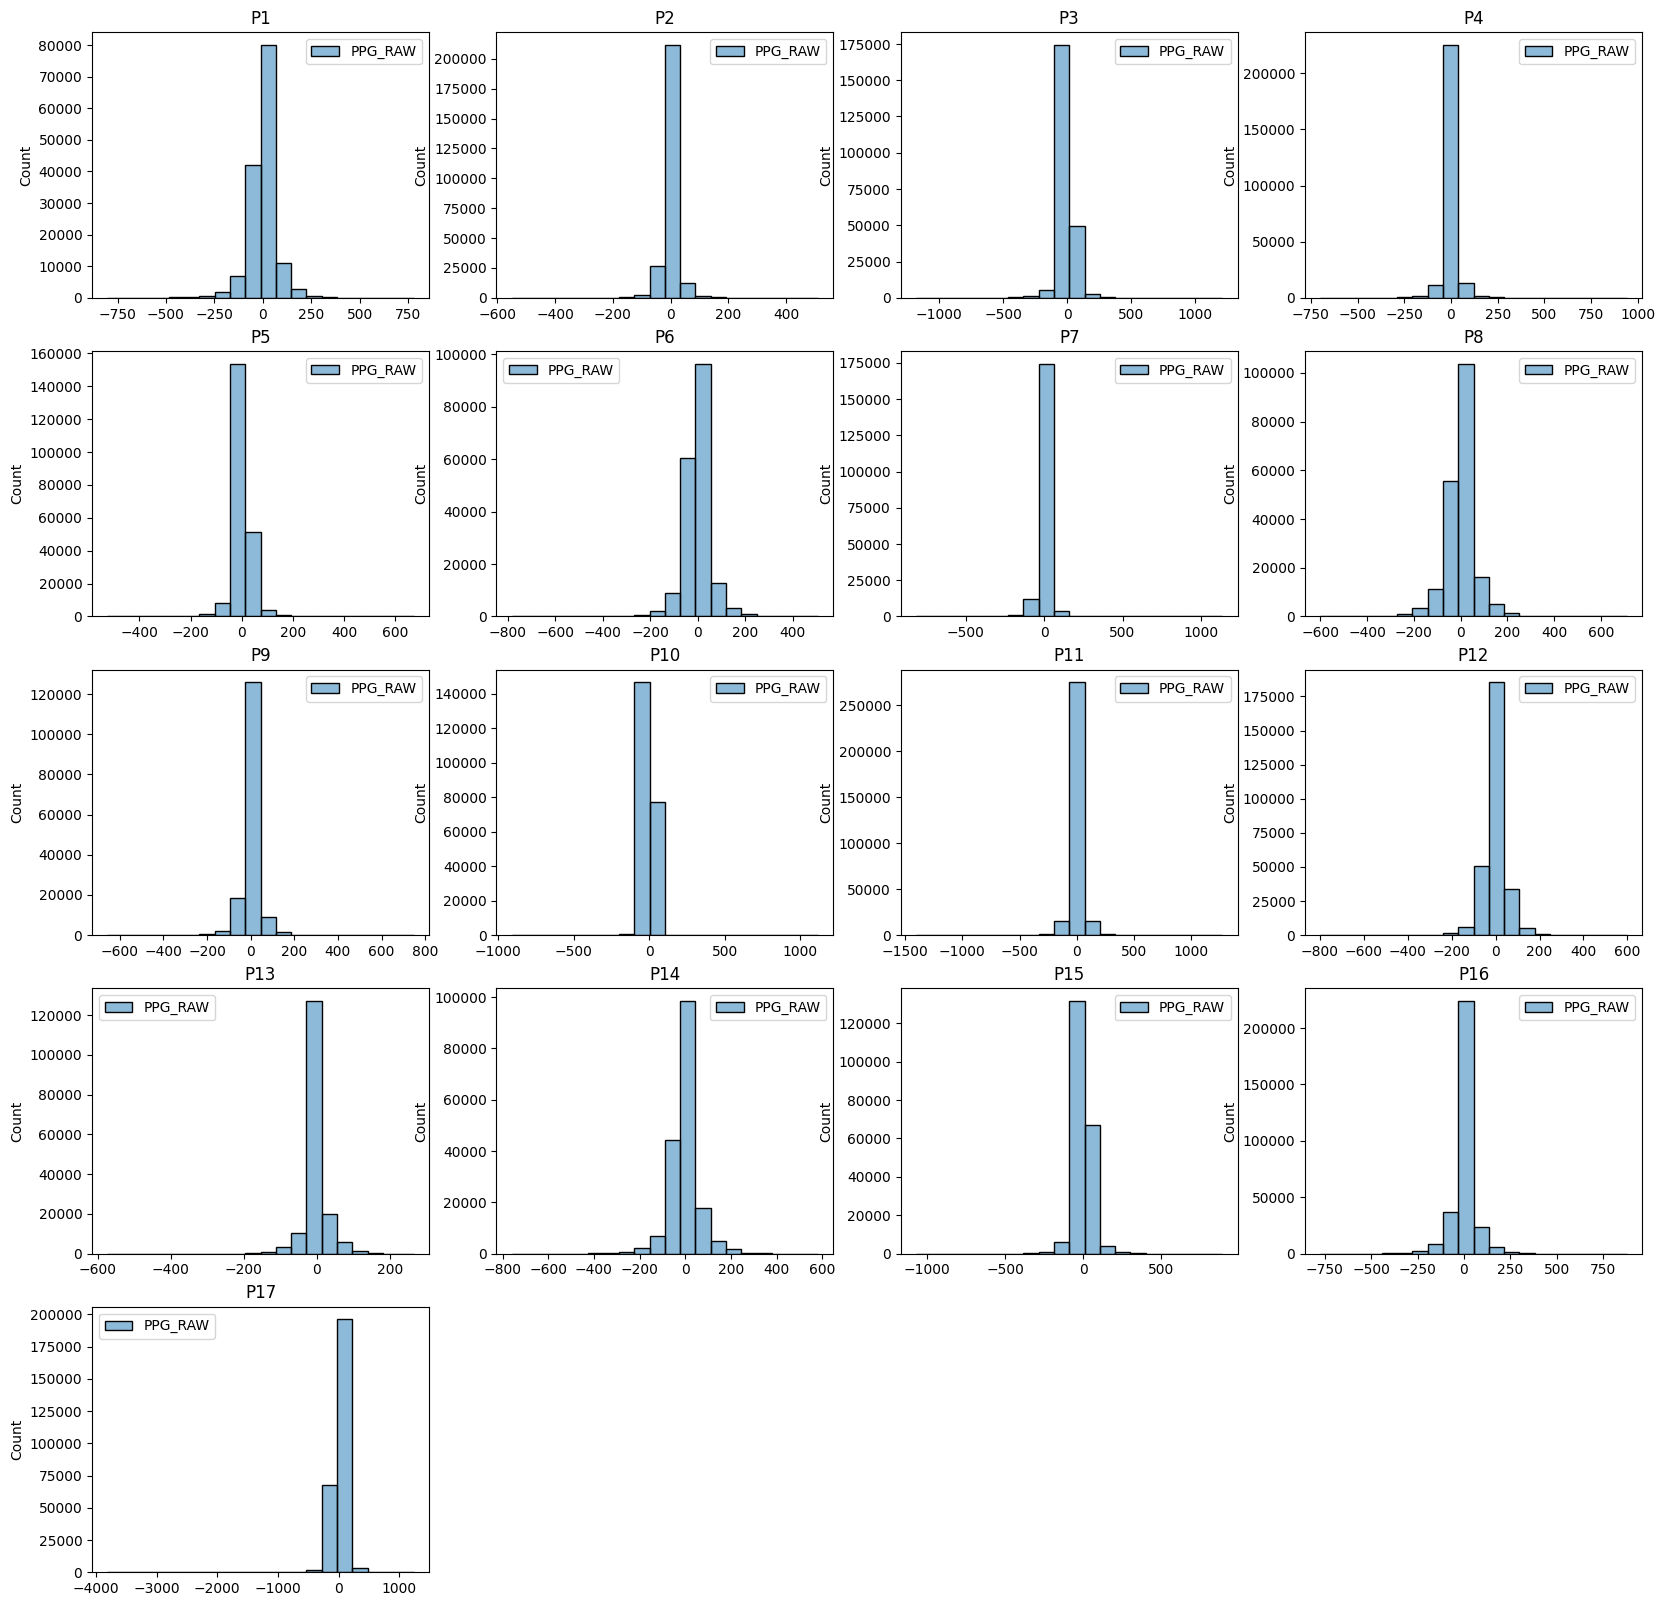

In [13]:
hist_plots(ppg_e4_dfs)

### Earbuds Data

## Cleaning the Data

### E4 PPG Data

We will be using `HeartPy` library to clean and extract features from the PPG data.

> First, the data is cleaned using the Butterworth Bandpass Filter. The cutoff range is used as 0.7 Hz (42 bpm) and 3.5 Hz (210 bpm).

In [14]:
# Butterworth Bandpass Filter
def bt_filter(df, column, lowcut, highcut, order):
    return hp.filter_signal(
        data=df[column].values,
        cutoff=[lowcut, highcut],
        sample_rate=FREQUENCY,
        order=order,
        filtertype='bandpass'
    ) 

In [15]:
# cleaned ppg data of all the participants using Butterworth Bandpass Filter
cleaned_ppg_e4_arrs = [bt_filter(df, "ppg_raw", 0.7, 3.5, 3) for df in ppg_e4_dfs]

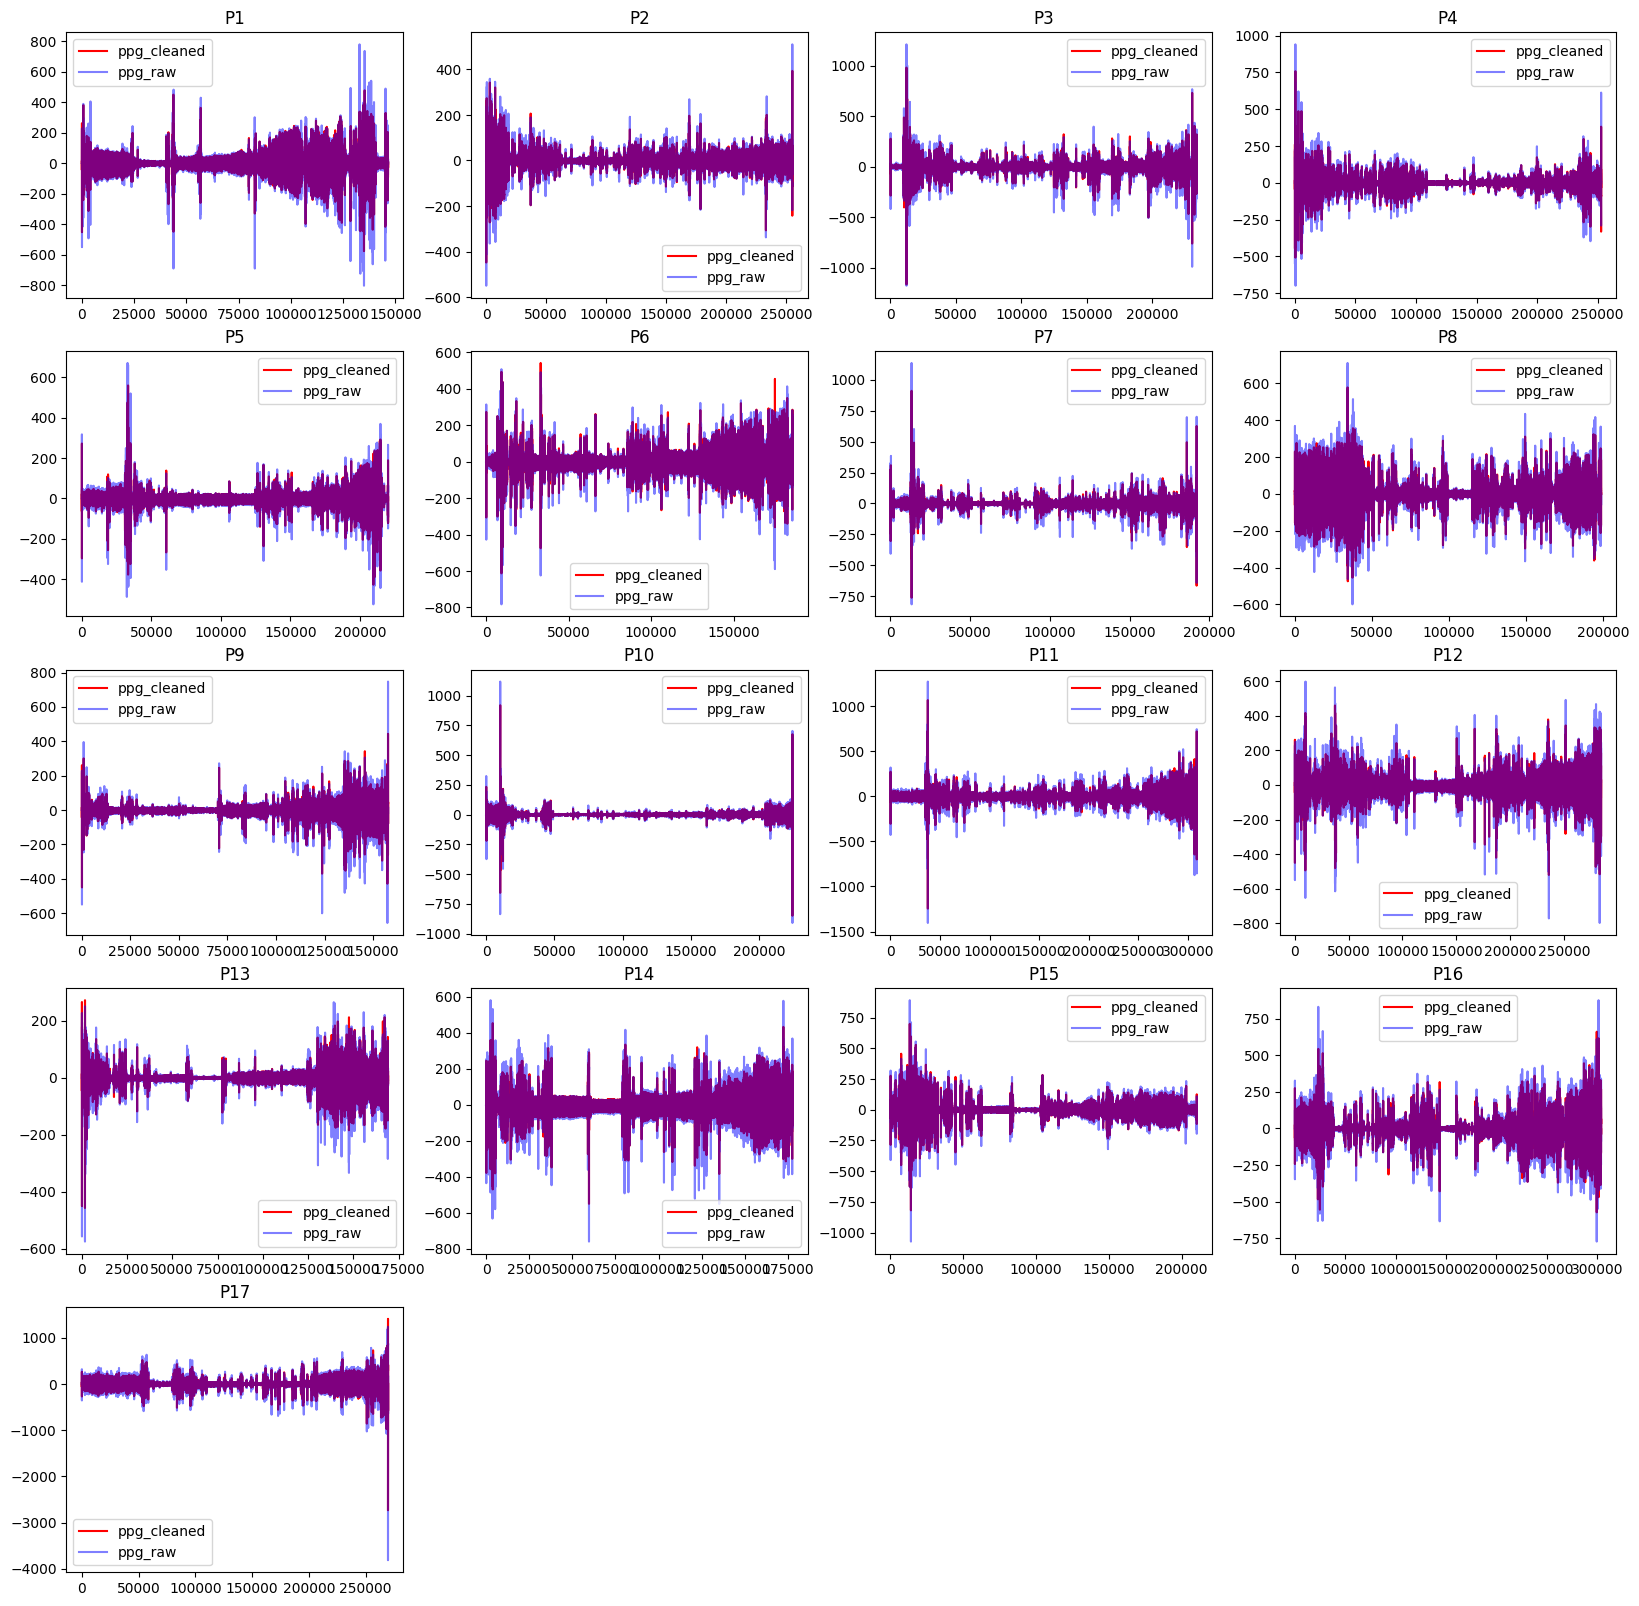

In [16]:
# plots with cleaned data
fig = plt.figure(figsize=(20, 20))

for i in range(len(cleaned_ppg_e4_arrs)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.title.set_text(f"P{i+1}")
    ax.plot(cleaned_ppg_e4_arrs[i], color="red", label="ppg_cleaned")
    ax.plot(ppg_e4_dfs[i]["ppg_raw"], alpha=0.5, color="blue", label="ppg_raw")
    ax.legend()

plt.show()

For E4 PPG data, a time window of `10s` is considered for PPG measurements.

In [19]:
# preprocess
def preprocess_e4(arr, window_size):
    out_cols = []
    out_arr = None

    try:
        for i in range(0, len(arr)-window_size+1):
            # process data
            working_data, measures = hp.process(arr[i:i+window_size], FREQUENCY)
            if i == 0:
                out_cols = list(measures.keys())
                out_arr = np.array([list(measures.values())])
            else:
                out_arr = np.append(out_arr, [list(measures.values())], axis=0)
    except:
        out_arr = np.append(out_arr, [[np.nan for _ in range(len(out_cols))]], axis=0)
    return pd.DataFrame(data=out_arr, columns=out_cols)

In [20]:
# new dataframe of inferred results
inferred_ppg_dfs = []
WINDOW_SIZE = 10 # 10 seconds

In [21]:
inferred_ppg_dfs.append(preprocess_e4(cleaned_ppg_e4_arrs[0], int(WINDOW_SIZE*FREQUENCY)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/yasith/.local/share/virtualenvs/weee-dataset-TkA7iVit/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724


/home/yasith/.local/share/virtualenvs/weee-dataset-TkA7iVit/lib/python3.10/site-packages/numpy/ma/core.py:5300: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/yasith/.local/share/virtualenvs/weee-dataset-TkA7iVit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<__array_function__ internals>:200: UserWarning: Warning: converting a masked element to nan.


2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177


/home/yasith/.local/share/virtualenvs/weee-dataset-TkA7iVit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yasith/.local/share/virtualenvs/weee-dataset-TkA7iVit/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


40005
40006
40007
40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
40021
40022
40023
40024
40025
40026
40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051
40052
40053
40054
40055
40056
40057
40058
40059
40060
40061
40062
40063
40064
40065
40066
40067
40068
40069
40070
40071
40072
40073
40074
40075
40076
40077
40078
40079
40080
40081
40082
40083
40084
40085
40086
40087
40088
40089
40090
40091
40092
40093
40094
40095
40096
40097
40098
40099
40100
40101
40102
40103
40104
40105
40106
40107
40108
40109
40110
40111
40112
40113
40114
40115
40116
40117
40118
40119
40120
40121
40122
40123
40124
40125
40126
40127
40128
40129
40130
40131
40132
40133
40134
40135
40136
40137
40138
40139
40140
40141
40142
40143
40144
40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
4017

In [27]:
inferred_ppg_dfs[0].tail()

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
145865,123.428571,486.111111,138.671705,107.750838,198.464155,0.833333,0.666667,140.6250,140.287017,99.573199,43884.364571,1.408883,0.457561
145866,123.428571,486.111111,138.671705,107.750838,198.464155,0.833333,0.666667,140.6250,140.287017,99.573199,43884.364571,1.408883,0.457561
145867,126.942149,472.656250,141.436461,91.962119,217.294263,1.000000,0.800000,117.1875,153.507176,81.789077,39443.356307,1.876866,0.264690
145868,126.942149,472.656250,141.436461,91.962119,217.294263,1.000000,0.800000,117.1875,153.507176,81.789077,39443.356307,1.876866,0.264690
145869,126.942149,472.656250,141.436461,91.962119,217.294263,1.000000,0.800000,117.1875,153.507176,81.789077,39443.356307,1.876866,0.264690


## Saving the Data

### User Characteristics

Let's load the demographic data of each users to embedd them into the preprocessed data.

In [23]:
demographic_df = pd.read_csv(os.path.join(DATASET_PATH, DATASET_VERSION, "Demographics.csv"))
demographic_df.drop(columns=["Comments"], inplace=True)

In [24]:
# lowering the case of the column names
demographic_df.columns = demographic_df.columns.str.lower()

In [25]:
demographic_df.head()

,participant,bmi,fat,muscle,water,bone,weight,height,gender,age
0,P01,24.7,33,14,49,4,70.6,166,F,29
1,P02,25.7,20,15,54,4,77.0,173,M,26
2,P03,20.6,23,16,57,5,61.0,172,F,26
3,P04,26.6,17,15,53,4,81.5,175,M,27
4,P05,24.8,31,14,48,4,66.0,163,F,33


#### Categorical Encoding

Gender is the only categorical variable available in the dataset. We encode it using an `Ordinal Encoder` by mapping values as follows.
- "M": 0
- "F": 1 

In [26]:
encoder = ce.OrdinalEncoder(
    cols=["gender"],
    return_df=True,
    mapping=[{
        "col": "gender",
        "mapping": {
            "M": 0,
            "F": 1
        }
    }]
)
encoder.fit_transform(demographic_df)

,participant,bmi,fat,muscle,water,bone,weight,height,gender,age
0,P01,24.7,33,14,49,4,70.6,166,1,29
1,P02,25.7,20,15,54,4,77.0,173,0,26
2,P03,20.6,23,16,57,5,61.0,172,1,26
3,P04,26.6,17,15,53,4,81.5,175,0,27
4,P05,24.8,31,14,48,4,66.0,163,1,33
5,P06,30.8,32,14,50,4,99.7,180,0,40
6,P07,25.8,18,14,50,4,71.0,166,0,34
7,P08,26.4,22,14,48,4,85.6,180,0,33
8,P09,26.4,19,14,49,4,76.0,177,0,27
9,P10,27.8,24,14,51,4,87.0,177,0,41
